In [1]:
import os
import pandas as pd
from tqdm import tqdm

from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem.Draw import MolsToGridImage
import matplotlib.pyplot as plt

In [2]:
# Disable warnings
from rdkit import RDLogger
import warnings

RDLogger.DisableLog("rdApp.*")
warnings.filterwarnings("ignore")

# Load dataset

In [3]:
amr_df = pd.read_csv("../data/processed/combined_bioassay_data.tsv", sep="\t")
amr_df.head()

,compound_inchikey,compound_smiles,compound_source,gram-positive,gram-negative,fungi,acid-fast,chemical_class,compound_superclass,compound_pathway,gram-positive_label,gram-negative_label,fungi_label,acid-fast_label,best_class
0,OOYGSFOGFJDDHP-KMCOLRRFSA-N,NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[...,chembl_34,5.0,5.0,NaN,6.0,"['Amino cyclitols', 'Aminoglycosides']","['Aminosugars and aminoglycosides', 'Polyols']",['Carbohydrates'],inactive,inactive,NaN,active,acid-fast
1,XIPHLJFTBFXVBS-UHFFFAOYSA-N,C=C(C(=O)c1ccc(F)cc1)c1ccc(Cl)cc1Cl,chembl_34,NaN,NaN,6.0,NaN,['Chalcones'],['Flavonoids'],['Shikimates and Phenylpropanoids'],NaN,NaN,active,NaN,fungi
2,OEFUWWDPRNNMRS-WDPNLORNSA-N,CC[C@H]1OC(=O)[C@H](C)[C@H]2OC3(CCN(C(=O)c4ccc...,chembl_34,6.0,6.5,NaN,NaN,['Erythromycins'],['Macrolides'],['Polyketides'],active,active,NaN,NaN,gram-negative
3,LBRXTHSVIORIGU-OLROFJLRSA-N,CC[C@H]1OC(=O)[C@H](C)[C@H]2OC3(CCN(C(=O)c4cnc...,chembl_34,6.0,6.0,NaN,NaN,['Erythromycins'],['Macrolides'],['Polyketides'],active,active,NaN,NaN,gram-positive
4,PHYLUFIYANLQSE-UHFFFAOYSA-N,CN1Cc2csc3c(C(=O)O)c(=O)c4cc(F)c(N5CCOC(CF)C5)...,chembl_34,7.5,7.0,NaN,NaN,[],['Tryptophan alkaloids'],['Alkaloids'],active,active,NaN,NaN,gram-positive


# Generate the scaffolds

In [4]:
murcko_scaffolds = []
murcko_scaffolds_inchikey = []
skipped = set()

remover = SaltRemover()

for smiles in tqdm(amr_df["compound_smiles"].values):
    # Canonicalize the smiles
    can_smiles = Chem.CanonSmiles(smiles)

    # Generate the mol object
    mol = Chem.MolFromSmiles(can_smiles)
    stripped = remover.StripMol(mol)

    # Generate the Murcko scaffold
    scaffold = MurckoScaffold.GetScaffoldForMol(stripped)
    if scaffold is not None and scaffold.GetNumAtoms() > 0:
        murcko_scaffolds.append(Chem.MolToSmiles(scaffold))
        murcko_scaffolds_inchikey.append(
            Chem.InchiToInchiKey(Chem.MolToInchi(scaffold))
        )
    else:
        murcko_scaffolds.append(None)
        murcko_scaffolds_inchikey.append(None)
        skipped.add(smiles)

100%|██████████| 74202/74202 [01:37<00:00, 759.27it/s] 


In [5]:
len(skipped)

1132

In [6]:
amr_df["murcko_scaffold"] = murcko_scaffolds

# Getting counts for each scaffold type

In [7]:
m1 = amr_df["murcko_scaffold"] == None
amr_df = amr_df[~m1]

In [8]:
# sort values by occurrence of scaffold
scaffold_counts = amr_df["murcko_scaffold"].value_counts()
scaffold_counts = scaffold_counts.reset_index()
scaffold_counts.columns = ["murcko_scaffold", "count"]

In [9]:
scaffold_counts.shape

(24506, 2)

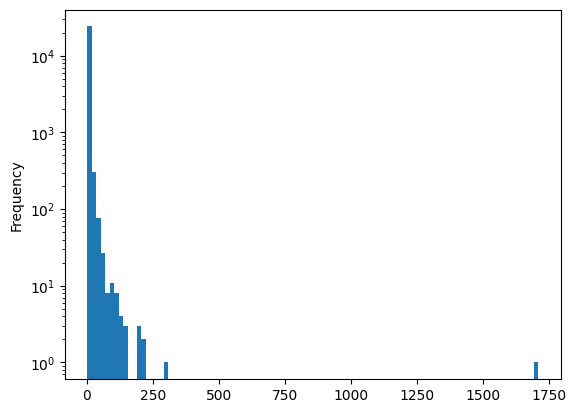

In [10]:
scaffold_counts["count"].plot(kind="hist", bins=100)
plt.yscale("log")

# Visualize the top and bottom scaffolds

In [11]:
top_mols_to_plot = [
    Chem.MolFromSmiles(i) for i in scaffold_counts.head(10)["murcko_scaffold"]
]
img = MolsToGridImage(
    top_mols_to_plot,
    molsPerRow=5,
    subImgSize=(300, 300),
    legends=[f"Occurence: {j}" for i, j in scaffold_counts.head(10).values],
    returnPNG=False,
)
img.save("../figures/figure_3.png")

In [12]:
bottom_mols_to_plot = [
    Chem.MolFromSmiles(i) for i in scaffold_counts.tail(10)["murcko_scaffold"]
]
img = MolsToGridImage(
    bottom_mols_to_plot,
    molsPerRow=5,
    subImgSize=(300, 300),
    legends=[f"Occurence: {j}" for i, j in scaffold_counts.tail(10).values],
    returnPNG=False,
)
img.save("../figures/suuplemetary_figure_1.png")